In [15]:
import os
import pandas as pd
import numpy as np
# When loading the tf library the kernel crashes in VSCode
# https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes-when-using-tensorflow
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.style.use('default')
np.random.seed(3000)

# Set style parameters for publication quality
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelpad': 8,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': True,
    'legend.fontsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    # 'savefig.dpi': 300,
    # 'savefig.bbox': 'tight',
    'savefig.transparent': True
})

sns.set(style="ticks")
plt.rcParams['text.usetex'] = True

# set tf to be run on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
%load_ext line_profiler

In [16]:
def load_training_data(csv_path):
    """
    Load real training statistics data from CSV file.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file containing training statistics
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the loaded training data with error values
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"Successfully loaded data from {csv_path}")
        print(f"Data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Convert string columns to numeric if needed
        numeric_cols = ['n_neurons', 'n_edges', 'batch_size', 'seq_len', 
                        'mean_step_time', 'sem_step_time', 
                        'mean_gpu_memory', 'sem_gpu_memory',
                        'mean_rate', 'sem_rate']
        
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        # If we have SEM values already, use them directly
        if 'sem_step_time' in df.columns and 'sem_gpu_memory' in df.columns:
            # Data already has error values
            pass
        else:
            # Group by configuration parameters and calculate statistics
            print("Computing statistics from raw data...")
            grouped = df.groupby(['sim_name', 'n_neurons', 'n_edges', 'batch_size', 'seq_len', 'mode']).agg({
                'mean_step_time': ['mean', 'sem'],
                'mean_gpu_memory': ['mean', 'sem'],
                'mean_rate': ['mean', 'sem']
            }).reset_index()
            
            # Flatten multi-level column names
            grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
            df = grouped
            
        # Print some statistics about the dataset
        print(f"Unique neuron counts: {sorted(df['n_neurons'].unique())}")
        print(f"Unique batch sizes: {sorted(df['batch_size'].unique())}")
        print(f"Unique sequence lengths: {sorted(df['seq_len'].unique())}")
        if 'mode' in df.columns:
            print(f"Modes: {sorted(df['mode'].unique())}")
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return an empty DataFrame with the expected columns
        return pd.DataFrame(columns=['n_neurons', 'n_edges', 'batch_size', 'seq_len', 
                                    'mean_step_time', 'sem_step_time',
                                    'mean_gpu_memory', 'sem_gpu_memory',
                                    'mean_rate', 'sem_rate', 'mode'])

path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_thesis_data.csv'
# open as pd dataframe
df = load_training_data(path)
# Rename columns to match the expected format in the plot functions
df = df.rename(columns={
    'n_neurons': 'neurons',
    'mean_step_time': 'step_time', 
    'sem_step_time': 'step_time_sem',
    'mean_gpu_memory': 'memory',
    'sem_gpu_memory': 'memory_sem'
})

# Separate train and test data
train_df = df[df['mode'] == 'train']
test_df = df[df['mode'] == 'test']

train_df

Successfully loaded data from /home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_thesis_data.csv
Data shape: (97, 12)
Columns: ['sim_name', 'n_neurons', 'n_edges', 'batch_size', 'seq_len', 'mean_rate', 'sem_rate', 'mean_step_time', 'sem_step_time', 'mean_gpu_memory', 'sem_gpu_memory', 'mode']
Unique neuron counts: [1000, 5000, 10000, 20000, 40000, 65871, 203816]
Unique batch sizes: [1, 2, 4, 6, 10]
Unique sequence lengths: [400, 1000, 2000, 4000]
Modes: ['test', 'train']


,sim_name,neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,step_time,step_time_sem,memory,memory_sem,mode
0,b_z2i5,1000,544263,1,1000,0.0036,0.0,3.6415,0.0203,2.1643,0.0101,train
1,b_4lff,5000,3074601,1,1000,0.0036,0.0,3.7886,0.0034,1.4148,0.0025,train
2,b_0e9x,10000,6645432,1,1000,0.0035,0.0,3.9436,0.0034,1.9357,0.0009,train
3,b_z62m,20000,14807994,1,1000,0.0036,0.0,4.7752,0.0046,3.5159,0.0012,train
4,b_oie9,5000,3074601,2,1000,0.0037,0.0,4.0466,0.0071,2.8487,0.0144,train
5,b_h173,1000,544263,2,1000,0.0036,0.0,4.3920,0.0472,2.6519,0.0111,train
6,b_178o,10000,6645432,2,1000,0.0036,0.0,4.3545,0.0062,3.3010,0.0102,train
7,b_r5w0,1000,544263,4,1000,0.0036,0.0,3.7842,0.0071,2.8949,0.0118,train
8,b_oxqn,20000,14807994,2,1000,0.0037,0.0,5.3377,0.0078,5.5229,0.0083,train
9,b_9s38,5000,3074601,4,1000,0.0038,0.0,4.4946,0.0073,3.0014,0.0057,train


In [17]:
train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
# filter by batch size 1
train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()
train_seq1000

,sim_name,neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,step_time,step_time_sem,memory,memory_sem,mode
0,b_z2i5,1000,544263,1,1000,0.0036,0.0,3.6415,0.0203,2.1643,0.0101,train
1,b_4lff,5000,3074601,1,1000,0.0036,0.0,3.7886,0.0034,1.4148,0.0025,train
2,b_0e9x,10000,6645432,1,1000,0.0035,0.0,3.9436,0.0034,1.9357,0.0009,train
3,b_z62m,20000,14807994,1,1000,0.0036,0.0,4.7752,0.0046,3.5159,0.0012,train
15,b_5pak,40000,31863080,1,1000,0.0035,0.0,7.0750,0.0074,6.8097,0.0015,train
18,b_a89t,65871,54378241,1,1000,0.0036,0.0,11.4764,0.0085,11.2929,0.0027,train
27,b_fj8t,1000,544263,1,1000,0.0036,0.0,3.5625,0.0070,1.8458,0.0062,train
28,b_rqa8,5000,3074601,1,1000,0.0036,0.0,3.8644,0.0067,1.6631,0.0000,train
29,b_rk5p,10000,6645432,1,1000,0.0035,0.0,3.9731,0.0071,1.8820,0.0007,train
30,b_voh0,20000,14807994,1,1000,0.0036,0.0,4.7256,0.0080,3.4617,0.0009,train


Training linear fit: y = 1.49e-04x + 2.33e+00
Testing linear fit: y = 4.07e-05x + 7.64e-01


/tmp/ipykernel_4041217/2887753162.py:101: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left',
/tmp/ipykernel_4041217/2887753162.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


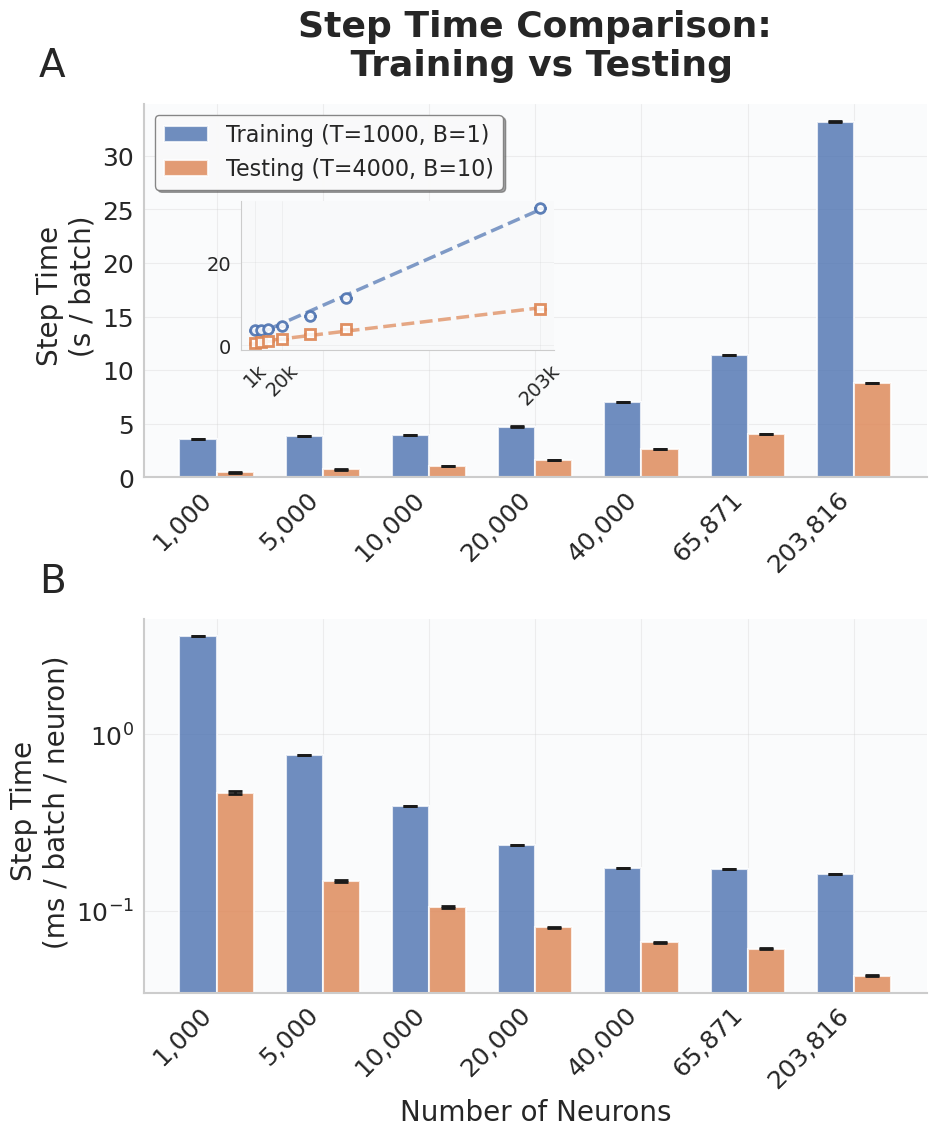

In [18]:
def create_normalized_step_time_comparison(train_df, test_df, output_dir=''):
    """
    Create a specialized comparison between train and test data for sequence length 4000,
    with step time normalized by batch size to provide a fair comparison.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        DataFrame containing the training data
    test_df : pandas.DataFrame
        DataFrame containing the testing data
    output_dir : str
        Directory to save the generated figures
    """
    # Set publication-ready style
    plt.style.use('default')
    sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})
    sns.set_palette("deep")
    
    # Create output directory if it doesn't exist
    # os.makedirs(output_dir, exist_ok=True)
    # Filter for sequence length 1000 in training data
    train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
    train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()

    # Prepare test data (might not have seq_len column if it's constant)
    test_data = test_df.copy()
    # Normalize step times by batch size for fair comparison
    if not train_seq1000.empty:
        train_seq1000['normalized_step_time'] = train_seq1000['step_time'] / train_seq1000['batch_size']
        train_seq1000['normalized_step_time_sem'] = train_seq1000['step_time_sem'] / train_seq1000['batch_size']
    if not test_data.empty:
        test_data['normalized_step_time'] = test_data['step_time'] / test_data['batch_size']
        test_data['normalized_step_time_sem'] = test_data['step_time_sem'] / test_data['batch_size']

    # Create figure for comparison
    if not train_seq1000.empty and not test_data.empty:
        # Create figure with improved styling
        fig = plt.figure(figsize=(10, 12))
        
        # Define colors using seaborn palette
        colors = sns.color_palette("deep", 2)
        train_color = colors[0]  # Blue
        test_color = colors[1]   # Orange
        
        # Panel 1: Normalized Step Time vs Neuron Count (with inset for line plot)
        ax1 = plt.subplot(2, 1, 1)
        # Get common neuron values
        common_neurons = sorted(set(train_seq1000['neurons'].unique()) & set(test_data['neurons'].unique()))
        # Calculate average normalized step times and SEM for each neuron count
        train_norm_times = []
        test_norm_times = []
        train_norm_sems = []
        test_norm_sems = []
        
        for neuron in common_neurons:
            # Filter data for this neuron count
            train_neurons = train_seq1000[train_seq1000['neurons'] == neuron]
            test_neurons = test_data[test_data['neurons'] == neuron]
            # Calculate mean normalized step time and SEM for each mode
            train_norm_time = train_neurons['normalized_step_time'].mean()
            test_norm_time = test_neurons['normalized_step_time'].mean()
            train_norm_sem = train_neurons['normalized_step_time_sem'].mean()
            test_norm_sem = test_neurons['normalized_step_time_sem'].mean()
            
            train_norm_times.append(train_norm_time)
            test_norm_times.append(test_norm_time)
            train_norm_sems.append(train_norm_sem)
            test_norm_sems.append(test_norm_sem)
        
        # Plot bar chart comparison with error bars
        x = np.arange(len(common_neurons))
        width = 0.35

        bars1 = ax1.bar(x - width/2, train_norm_times, width, 
                       label='Training (T=1000, B=1)', color=train_color,
                       yerr=train_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        bars2 = ax1.bar(x + width/2, test_norm_times, width, 
                       label='Testing (T=4000, B=10)', color=test_color,
                       yerr=test_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        
        ax1.set_ylabel('Step Time \n (s / batch)', fontsize=20, fontweight='normal')
        ax1.set_title('Step Time Comparison:\n Training vs Testing', 
                     fontweight='bold', fontsize=26, pad=20)
        ax1.set_xticks(x)
        ax1.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=18, ha='right')
        ax1.tick_params(axis='y', labelsize=18)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # Improve legend
        legend = ax1.legend(fontsize=16, loc='upper left', frameon=True, 
                           fancybox=True, shadow=True, framealpha=0.95)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('gray')
        
        # Create inset for line plot - FIXED: provide 4-tuple for bbox_to_anchor
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left', 
                             borderpad=7, #bbox_to_anchor=(0.5, 0.5, 0.45, 0.45), 
                             bbox_transform=ax1.transAxes)

        # Plot normalized step time vs neuron count for both modes (line plot) with error bars
        ax_inset.errorbar(common_neurons, train_norm_times, yerr=train_norm_sems,
                         fmt='o', label='Training', color=train_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        ax_inset.errorbar(common_neurons, test_norm_times, yerr=test_norm_sems,
                         fmt='s', label='Testing', color=test_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        
        # Add linear fits and print fitting parameters
        train_fit = np.polyfit(common_neurons, train_norm_times, 1)
        train_fit_line = np.poly1d(train_fit)
        ax_inset.plot(common_neurons, train_fit_line(common_neurons), '--', 
                     color=train_color, linewidth=2.5, alpha=0.7)
        
        test_fit = np.polyfit(common_neurons, test_norm_times, 1)
        test_fit_line = np.poly1d(test_fit)
        ax_inset.plot(common_neurons, test_fit_line(common_neurons), '--', 
                     color=test_color, linewidth=2.5, alpha=0.7)
        
        # Print fitting parameters
        print(f"Training linear fit: y = {train_fit[0]:.2e}x + {train_fit[1]:.2e}")
        print(f"Testing linear fit: y = {test_fit[0]:.2e}x + {test_fit[1]:.2e}")
        
        ax_inset.tick_params(axis='both', labelsize=14)
        ax_inset.set_xticks(common_neurons[::3])
        ax_inset.set_xticklabels([f"{n//1000}k" for n in common_neurons[::3]], 
                                fontsize=14, rotation=45)
        ax_inset.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax_inset.set_facecolor('#f8f9fa')

        # Panel 2: Efficiency metrics
        ax2 = plt.subplot(2, 1, 2)
        
        # Calculate efficiency metrics (time per neuron) for both modes
        train_time_per_neuron = [t/n for t, n in zip(train_norm_times, common_neurons)]
        test_time_per_neuron = [t/n for t, n in zip(test_norm_times, common_neurons)]
        # Calculate SEM for efficiency metrics
        train_time_per_neuron_sem = [sem/n for sem, n in zip(train_norm_sems, common_neurons)]
        test_time_per_neuron_sem = [sem/n for sem, n in zip(test_norm_sems, common_neurons)]
        
        # Create a grouped bar chart with error bars
        bar_width = 0.35
        x = np.arange(len(common_neurons))
        
        bars3 = ax2.bar(x - bar_width/2, 
                       [t * 1000 for t in train_time_per_neuron], # convert to ms
                       bar_width, 
                       label='Training', 
                       color=train_color,
                       yerr=[sem * 1000 for sem in train_time_per_neuron_sem],
                       capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        
        bars4 = ax2.bar(x + bar_width/2, 
                       [t * 1000 for t in test_time_per_neuron], # convert to ms
                       bar_width, 
                       label='Testing', 
                       color=test_color,
                       yerr=[sem * 1000 for sem in test_time_per_neuron_sem],
                       capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        
        # Set log scale for y-axis
        ax2.set_yscale('log')
        ax2.set_xlabel('Number of Neurons', fontsize=20, fontweight='normal')
        ax2.set_ylabel('Step Time \n (ms / batch / neuron)', fontsize=20, fontweight='normal')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=18, ha='right')
        ax2.tick_params(axis='y', labelsize=18)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # # Improve legend for second panel
        # legend2 = ax2.legend(fontsize=18, loc='upper left', frameon=True, 
        #                     fancybox=True, shadow=True, framealpha=0.95)
        # legend2.get_frame().set_facecolor('white')
        # legend2.get_frame().set_edgecolor('gray')
        
        # Add subtle background colors to distinguish panels
        ax1.set_facecolor('#fafbfc')
        ax2.set_facecolor('#fafbfc')
        
        # Improve spacing and layout
        plt.tight_layout(pad=3.0)
        
        # Add panel labels
        ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=28, 
                fontweight='normal', va='bottom', ha='right')
        ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=28, 
                fontweight='normal', va='bottom', ha='right')
        
        # Remove top and right spines for cleaner look
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
        
        plt.show()
        
create_normalized_step_time_comparison(train_df, test_df, output_dir='')

In [19]:
train_df

,sim_name,neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,step_time,step_time_sem,memory,memory_sem,mode
0,b_z2i5,1000,544263,1,1000,0.0036,0.0,3.6415,0.0203,2.1643,0.0101,train
1,b_4lff,5000,3074601,1,1000,0.0036,0.0,3.7886,0.0034,1.4148,0.0025,train
2,b_0e9x,10000,6645432,1,1000,0.0035,0.0,3.9436,0.0034,1.9357,0.0009,train
3,b_z62m,20000,14807994,1,1000,0.0036,0.0,4.7752,0.0046,3.5159,0.0012,train
4,b_oie9,5000,3074601,2,1000,0.0037,0.0,4.0466,0.0071,2.8487,0.0144,train
5,b_h173,1000,544263,2,1000,0.0036,0.0,4.3920,0.0472,2.6519,0.0111,train
6,b_178o,10000,6645432,2,1000,0.0036,0.0,4.3545,0.0062,3.3010,0.0102,train
7,b_r5w0,1000,544263,4,1000,0.0036,0.0,3.7842,0.0071,2.8949,0.0118,train
8,b_oxqn,20000,14807994,2,1000,0.0037,0.0,5.3377,0.0078,5.5229,0.0083,train
9,b_9s38,5000,3074601,4,1000,0.0038,0.0,4.4946,0.0073,3.0014,0.0057,train


/tmp/ipykernel_4041217/2437754807.py:101: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left',
/tmp/ipykernel_4041217/2437754807.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


Training linear fit: y = 1.67e-04x + 5.99e-01
Testing linear fit: y = 8.62e-06x + 5.72e-01


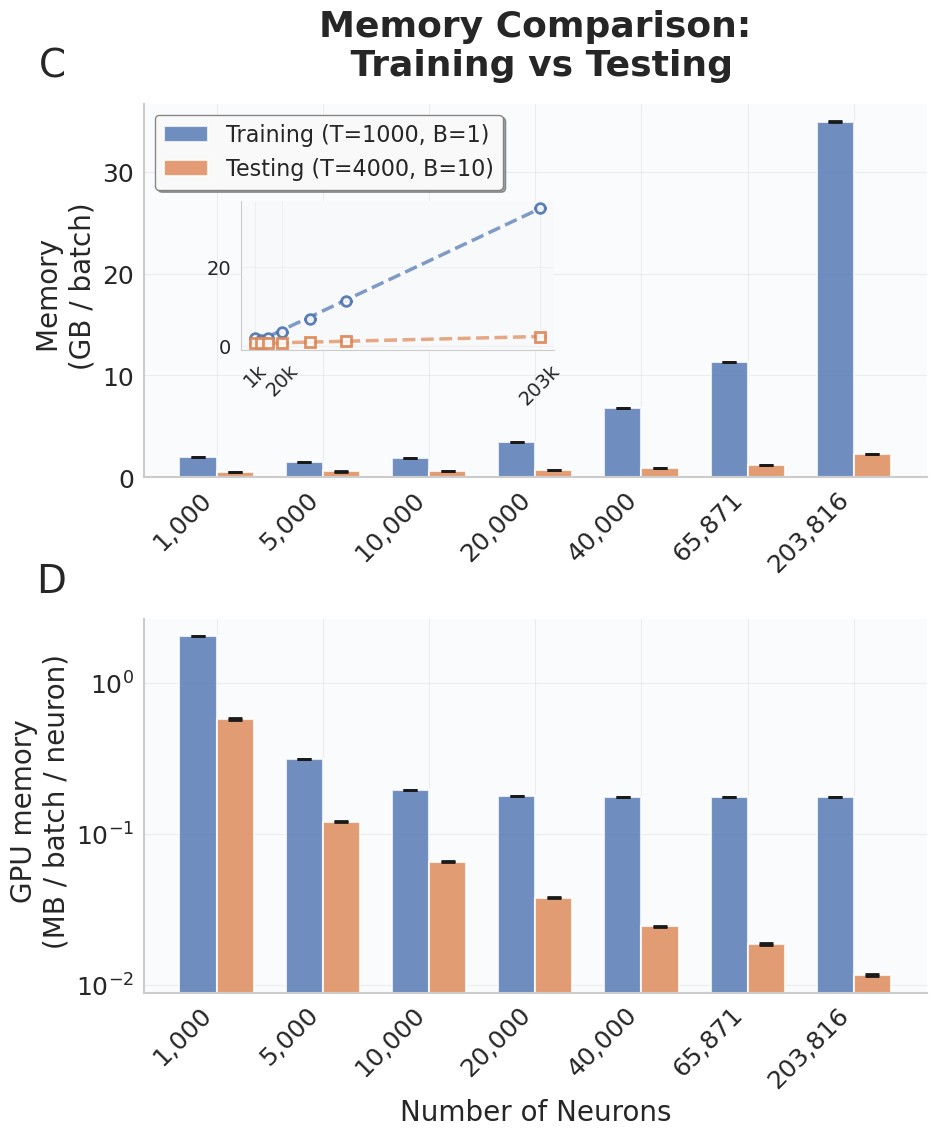

In [20]:
def create_normalized_memory_comparison(train_df, test_df, output_dir=''):
    """
    Create a specialized comparison between train and test data for sequence length 1000,
    with step time normalized by batch size to provide a fair comparison.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        DataFrame containing the training data
    test_df : pandas.DataFrame
        DataFrame containing the testing data
    output_dir : str
        Directory to save the generated figures
    """
    # Set publication-ready style
    plt.style.use('default')
    sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})
    sns.set_palette("deep")
    
    # Create output directory if it doesn't exist
    # os.makedirs(output_dir, exist_ok=True)
    # Filter for sequence length 1000 in training data
    train_seq1000 = train_df[train_df['seq_len'] == 1000] if 'seq_len' in train_df.columns else pd.DataFrame()
    train_seq1000 = train_seq1000[train_seq1000['batch_size'] == 1] if 'batch_size' in train_seq1000.columns else pd.DataFrame()

    # Prepare test data (might not have seq_len column if it's constant)
    test_data = test_df.copy()
    # Normalize step times by batch size for fair comparison
    if not train_seq1000.empty:
        train_seq1000['normalized_memory'] = train_seq1000['memory'] / train_seq1000['batch_size']
        train_seq1000['normalized_memory_sem'] = train_seq1000['memory_sem'] / train_seq1000['batch_size']
    if not test_data.empty:
        test_data['normalized_memory'] = test_data['memory'] / test_data['batch_size']
        test_data['normalized_memory_sem'] = test_data['memory_sem'] / test_data['batch_size']

    # Create figure for comparison
    if not train_seq1000.empty and not test_data.empty:
        # Create figure with improved styling
        fig = plt.figure(figsize=(10, 12))
        
        # Define colors using seaborn palette
        colors = sns.color_palette("deep", 2)
        train_color = colors[0]  # Blue
        test_color = colors[1]   # Orange
        
        # Panel 1: Normalized Step Time vs Neuron Count (with inset for line plot)
        ax1 = plt.subplot(2, 1, 1)
        # Get common neuron values
        common_neurons = sorted(set(train_seq1000['neurons'].unique()) & set(test_data['neurons'].unique()))
        # Calculate average normalized step times and SEM for each neuron count
        train_norm_times = []
        test_norm_times = []
        train_norm_sems = []
        test_norm_sems = []
        
        for neuron in common_neurons:
            # Filter data for this neuron count
            train_neurons = train_seq1000[train_seq1000['neurons'] == neuron]
            test_neurons = test_data[test_data['neurons'] == neuron]
            # Calculate mean normalized step time and SEM for each mode
            train_norm_time = train_neurons['normalized_memory'].mean()
            test_norm_time = test_neurons['normalized_memory'].mean()
            train_norm_sem = train_neurons['normalized_memory_sem'].mean() 
            test_norm_sem = test_neurons['normalized_memory_sem'].mean()

            train_norm_times.append(train_norm_time)
            test_norm_times.append(test_norm_time)
            train_norm_sems.append(train_norm_sem)
            test_norm_sems.append(test_norm_sem)
        
        # Plot bar chart comparison with error bars
        x = np.arange(len(common_neurons))
        width = 0.35

        bars1 = ax1.bar(x - width/2, train_norm_times, width, 
                       label='Training (T=1000, B=1)', color=train_color,
                       yerr=train_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)
        bars2 = ax1.bar(x + width/2, test_norm_times, width, 
                       label='Testing (T=4000, B=10)', color=test_color,
                       yerr=test_norm_sems, capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                       alpha=0.8, edgecolor='white', linewidth=1.5)

        ax1.set_ylabel('Memory \n (GB / batch)', fontsize=20, fontweight='normal')
        ax1.set_title('Memory Comparison:\n Training vs Testing', 
                     fontweight='bold', fontsize=26, pad=20)
        ax1.set_xticks(x)
        ax1.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=18, ha='right')
        ax1.tick_params(axis='y', labelsize=18)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # Improve legend
        legend = ax1.legend(fontsize=16, loc='upper left', frameon=True, 
                           fancybox=True, shadow=True, framealpha=0.95)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('gray')
        
        # Create inset for line plot - FIXED: provide 4-tuple for bbox_to_anchor
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        ax_inset = inset_axes(ax1, width="40%", height="40%", loc='upper left', 
                             borderpad=7, #bbox_to_anchor=(0.5, 0.5, 0.45, 0.45), 
                             bbox_transform=ax1.transAxes)

        # Plot normalized step time vs neuron count for both modes (line plot) with error bars
        ax_inset.errorbar(common_neurons, train_norm_times, yerr=train_norm_sems,
                         fmt='o', label='Training', color=train_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        ax_inset.errorbar(common_neurons, test_norm_times, yerr=test_norm_sems,
                         fmt='s', label='Testing', color=test_color, 
                         linewidth=3, markersize=7, capsize=4, capthick=2,
                         markerfacecolor='white', markeredgewidth=2, alpha=0.9)
        
        # Add linear fits and print fitting parameters
        train_fit = np.polyfit(common_neurons, train_norm_times, 1)
        train_fit_line = np.poly1d(train_fit)
        ax_inset.plot(common_neurons, train_fit_line(common_neurons), '--', 
                     color=train_color, linewidth=2.5, alpha=0.7)
        
        test_fit = np.polyfit(common_neurons, test_norm_times, 1)
        test_fit_line = np.poly1d(test_fit)
        ax_inset.plot(common_neurons, test_fit_line(common_neurons), '--', 
                     color=test_color, linewidth=2.5, alpha=0.7)
        
        # Print fitting parameters
        print(f"Training linear fit: y = {train_fit[0]:.2e}x + {train_fit[1]:.2e}")
        print(f"Testing linear fit: y = {test_fit[0]:.2e}x + {test_fit[1]:.2e}")
        
        ax_inset.tick_params(axis='both', labelsize=14)
        ax_inset.set_xticks(common_neurons[::3])
        ax_inset.set_xticklabels([f"{n//1000}k" for n in common_neurons[::3]], 
                                fontsize=14, rotation=45)
        ax_inset.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax_inset.set_facecolor('#f8f9fa')

        # Panel 2: Efficiency metrics
        ax2 = plt.subplot(2, 1, 2)
        
        # Calculate efficiency metrics (time per neuron) for both modes
        train_time_per_neuron = [t/n for t, n in zip(train_norm_times, common_neurons)]
        test_time_per_neuron = [t/n for t, n in zip(test_norm_times, common_neurons)]
        # Calculate SEM for efficiency metrics
        train_time_per_neuron_sem = [sem/n for sem, n in zip(train_norm_sems, common_neurons)]
        test_time_per_neuron_sem = [sem/n for sem, n in zip(test_norm_sems, common_neurons)]
        
        # Create a grouped bar chart with error bars
        bar_width = 0.35
        x = np.arange(len(common_neurons))
        
        bars3 = ax2.bar(x - bar_width/2, 
                   [t * 1024 for t in train_time_per_neuron], # convert GB to MB
                   bar_width, 
                   label='Training', 
                   color=train_color,
                   yerr=[sem * 1024 for sem in train_time_per_neuron_sem], # convert GB to MB
                   capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                   alpha=0.8, edgecolor='white', linewidth=1.5)
        
        bars4 = ax2.bar(x + bar_width/2, 
                   [t * 1024 for t in test_time_per_neuron], # convert GB to MB
                   bar_width, 
                   label='Testing', 
                   color=test_color,
                   yerr=[sem * 1024 for sem in test_time_per_neuron_sem], # convert GB to MB
                   capsize=5, error_kw={'linewidth': 2, 'capthick': 2},
                   alpha=0.8, edgecolor='white', linewidth=1.5)
        
        # Set log scale for y-axis
        ax2.set_yscale('log')
        ax2.set_xlabel('Number of Neurons', fontsize=20, fontweight='normal')
        ax2.set_ylabel('GPU memory \n (MB / batch / neuron)', fontsize=20, fontweight='normal')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{n:,}" for n in common_neurons], rotation=45, 
                           fontsize=18, ha='right')
        ax2.tick_params(axis='y', labelsize=18)
        ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
        
        # # Improve legend for second panel
        # legend2 = ax2.legend(fontsize=18, loc='upper left', frameon=True, 
        #                     fancybox=True, shadow=True, framealpha=0.95)
        # legend2.get_frame().set_facecolor('white')
        # legend2.get_frame().set_edgecolor('gray')
        
        # Add subtle background colors to distinguish panels
        ax1.set_facecolor('#fafbfc')
        ax2.set_facecolor('#fafbfc')
        
        # Improve spacing and layout
        plt.tight_layout(pad=3.0)
        
        # Add panel labels
        ax1.text(-0.1, 1.05, 'C', transform=ax1.transAxes, fontsize=28, 
                fontweight='normal', va='bottom', ha='right')
        ax2.text(-0.1, 1.05, 'D', transform=ax2.transAxes, fontsize=28, 
                fontweight='normal', va='bottom', ha='right')
        
        # Remove top and right spines for cleaner look
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
        
        plt.show()
        
create_normalized_memory_comparison(train_df, test_df, output_dir='')

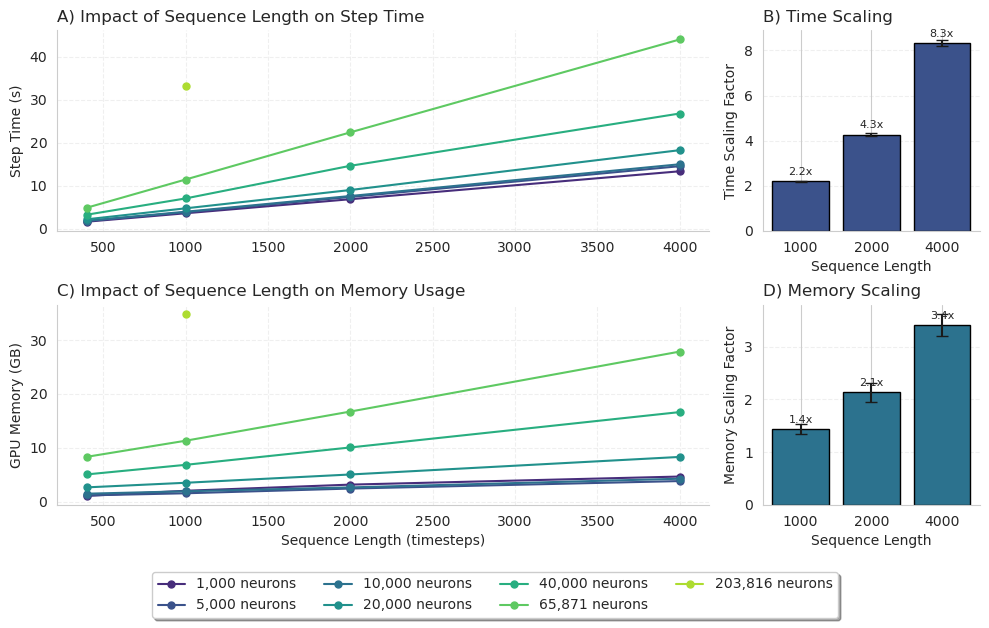

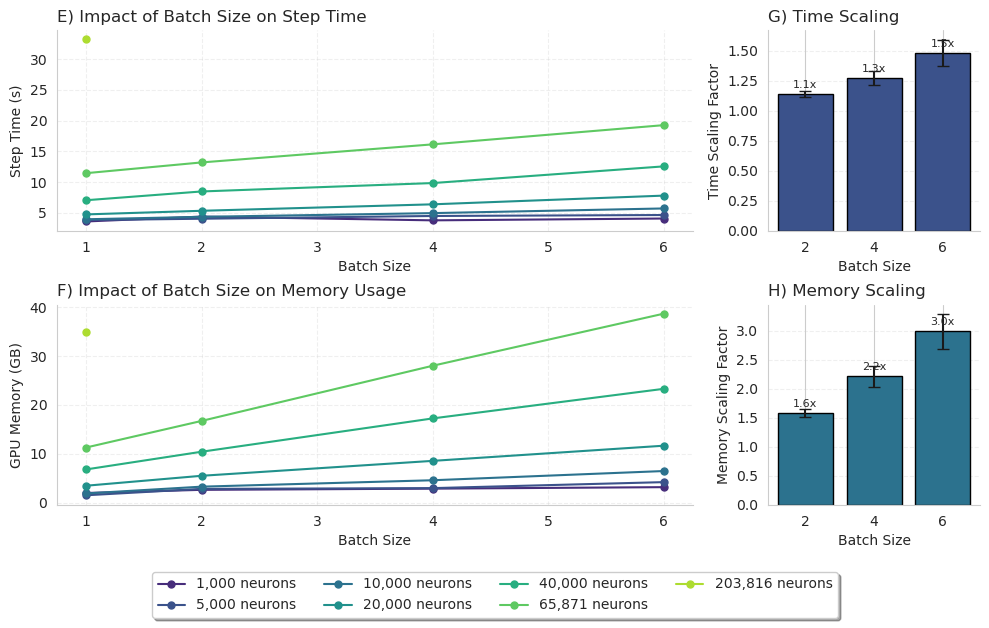

In [21]:
# import gridspec from matplotlib
from matplotlib.gridspec import GridSpec

def plot_performance_figures(df, output_dir='figures/performance'):
    """
    Create publication-quality figures visualizing the relationship between
    model parameters and performance metrics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the performance data
    output_dir : str
        Directory to save the generated figures
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Set a cohesive color palette with enough colors for all neuron counts and sequence lengths
    palette = sns.color_palette("viridis", max(len(df['neurons'].unique()), len(df['seq_len'].unique())))
    
    # =========================================================================
    # FIGURE 1: Sequence Length Impact
    # =========================================================================
    
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[3, 1])
    
    # Panel A: Step Time vs Sequence Length
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Prepare the data (average over samples)
    seq_len_data = df[df['batch_size'] == 1].groupby(['seq_len', 'neurons']).agg(
        mean_step_time=('step_time', 'mean'),
        sem_step_time=('step_time', 'sem')
    ).reset_index()
    
    # Create line plot with error bands
    for i, neurons in enumerate(sorted(df['neurons'].unique())):
        subset = seq_len_data[seq_len_data['neurons'] == neurons]
        # Multiply seq_len by 2 to account for two phases per training step
        ax1.plot(subset['seq_len'], subset['mean_step_time'], 
                marker='o', markersize=5, label=f"{neurons:,} neurons", 
                color=palette[i])
        ax1.fill_between(subset['seq_len'], 
                        subset['mean_step_time'] - subset['sem_step_time'],
                        subset['mean_step_time'] + subset['sem_step_time'],
                        alpha=0.2, color=palette[i])
    
    # Set x-ticks to only show values present in the data
    # ax1.set_xticks(sorted(df['seq_len'].unique()))
    
    # ax1.set_xlabel('Sequence Length (timesteps)')
    ax1.set_ylabel('Step Time (s)')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('A) Impact of Sequence Length on Step Time', fontweight='normal', loc='left')
    
    # Panel B: Memory vs Sequence Length
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    
    # Prepare the data
    seq_len_mem_data = df[df['batch_size'] == 1].groupby(['seq_len', 'neurons']).agg(
        mean_memory=('memory', 'mean'),
        sem_memory=('memory', 'sem')
    ).reset_index()
    
    # Create line plot with error bands
    for i, neurons in enumerate(sorted(df['neurons'].unique())):
        subset = seq_len_mem_data[seq_len_mem_data['neurons'] == neurons]
        ax2.plot(subset['seq_len'], subset['mean_memory'], 
                marker='o', markersize=5, label=f"{neurons:,} neurons", 
                color=palette[i])
        ax2.fill_between(subset['seq_len'], 
                        subset['mean_memory'] - subset['sem_memory'],
                        subset['mean_memory'] + subset['sem_memory'],
                        alpha=0.2, color=palette[i])
    
    ax2.set_xlabel('Sequence Length (timesteps)')
    ax2.set_ylabel('GPU Memory (GB)')
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('C) Impact of Sequence Length on Memory Usage', fontweight='normal', loc='left')
    
    # Panel C: Bar chart showing time scaling factor (normalized to smallest seq_len)
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Check if we have multiple sequence lengths to calculate scaling factors
    seq_len_values = sorted(df['seq_len'].unique())
    if len(seq_len_values) > 1:
        # Calculate scaling factors for sequence length 
        scaling_data = []
        baseline_seq_len = min(df['seq_len'].unique())
        
        # Compute scaling factors (average across neuron counts)
        for neurons in sorted(df['neurons'].unique()):
            neuron_data = df[(df['batch_size'] == 1) & (df['neurons'] == neurons)]
            baseline_data = neuron_data[neuron_data['seq_len'] == baseline_seq_len]
            
            # Check if baseline data exists
            if not baseline_data.empty:
                baseline_time = baseline_data['step_time'].mean()
                
                for seq_len in sorted(df['seq_len'].unique()):
                    if seq_len != baseline_seq_len:
                        seq_len_data = neuron_data[neuron_data['seq_len'] == seq_len]
                        if not seq_len_data.empty:
                            current_time = seq_len_data['step_time'].mean()
                            scaling_factor = current_time / baseline_time
                            scaling_data.append({
                                'neurons': neurons,
                                'seq_len': seq_len,
                                'scaling_factor': scaling_factor
                            })
        
        # Create DataFrame and check if we have data
        scaling_df = pd.DataFrame(scaling_data)
        
        if not scaling_df.empty and 'seq_len' in scaling_df.columns:
            # Compute average scaling factors across neuron counts
            avg_scaling = scaling_df.groupby('seq_len')['scaling_factor'].mean().reset_index()
            sem_scaling = scaling_df.groupby('seq_len')['scaling_factor'].sem().reset_index()
            
            # Plot scaling factors as bar chart
            bars = ax3.bar(avg_scaling['seq_len'].astype(str), avg_scaling['scaling_factor'], 
                          yerr=sem_scaling['scaling_factor'], capsize=4,
                          color=palette[1], edgecolor='black', linewidth=1)
            
            # Annoate bars with values
            for bar in bars:
                height = bar.get_height()
                ax3.annotate(f'{height:.1f}x',
                            xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=8)
        else:
            # Not enough data for scaling factor visualization
            ax3.text(0.5, 0.5, "Insufficient data\nfor scaling factors",
                    ha='center', va='center', transform=ax3.transAxes)
    else:
        # Not enough sequence length values
        ax3.text(0.5, 0.5, "Multiple sequence lengths\nrequired for scaling factors",
                ha='center', va='center', transform=ax3.transAxes)
    
    ax3.set_xlabel('Sequence Length')
    ax3.set_ylabel('Time Scaling Factor')
    ax3.set_title('B) Time Scaling', fontweight='normal', loc='left')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Panel D: Memory scaling factors
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Check if we have data to calculate batch memory scaling factors
    seq_len_values = sorted(df['seq_len'].unique())

    if len(seq_len_values) > 1:
        try:
            # Calculate scaling factors for batch size memory impact
            batch_mem_scaling_data = []
            baseline_seq_len = min(df['seq_len'].unique())
            
            for neurons in sorted(df['neurons'].unique()):
                neuron_data = df[(df['batch_size'] == 1) & (df['neurons'] == neurons)]
                if not neuron_data.empty and baseline_seq_len in neuron_data['seq_len'].values:
                    baseline_mem = neuron_data[neuron_data['seq_len'] == baseline_seq_len]['memory'].mean()

                    for batch_size in sorted(df['seq_len'].unique()):
                        if batch_size != baseline_seq_len and batch_size in neuron_data['seq_len'].values:
                            current_mem = neuron_data[neuron_data['seq_len'] == batch_size]['memory'].mean()
                            scaling_factor = current_mem / baseline_mem
                            batch_mem_scaling_data.append({
                                'neurons': neurons,
                                'seq_len': batch_size,
                                'scaling_factor': scaling_factor
                            })
            
            # If we have scaling data, create DataFrame and generate visualization
            if batch_mem_scaling_data:
                batch_mem_scaling_df = pd.DataFrame(batch_mem_scaling_data)
                
                # Compute average scaling factors
                avg_batch_mem_scaling = batch_mem_scaling_df.groupby('seq_len')['scaling_factor'].mean().reset_index()
                sem_batch_mem_scaling = batch_mem_scaling_df.groupby('seq_len')['scaling_factor'].sem().reset_index()
                
                # Plot memory scaling factors
                bars = ax4.bar(avg_batch_mem_scaling['seq_len'].astype(str), 
                              avg_batch_mem_scaling['scaling_factor'],
                              yerr=sem_batch_mem_scaling['scaling_factor'], 
                              capsize=4, color=palette[2], 
                              edgecolor='black', linewidth=1)
                
                # Annotate bars with values
                for bar in bars:
                    height = bar.get_height()
                    ax4.annotate(f'{height:.1f}x',
                                xy=(bar.get_x() + bar.get_width()/2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom',
                                fontsize=8)
            else:
                # Not enough data for batch scaling factors
                ax4.text(0.5, 0.5, "Insufficient data\nfor memory scaling factors",
                        ha='center', va='center', transform=ax4.transAxes)
        except Exception as e:
            # Handle any errors during calculation
            print(f"Warning: Could not calculate batch memory scaling factors: {e}")
            ax4.text(0.5, 0.5, "Error calculating\nmemory scaling factors",
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        # Not enough batch size values
        ax4.text(0.5, 0.5, "Multiple batch sizes\nrequired for scaling factors",
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.set_xlabel('Sequence Length')
    ax4.set_ylabel('Memory Scaling Factor')
    ax4.set_title('D) Memory Scaling', fontweight='normal', loc='left')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # Add legend for the whole figure
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              fancybox=True, shadow=True, ncol=4)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    # plt.savefig(os.path.join(output_dir, 'sequence_length_impact.png'), dpi=300)
    # plt.savefig(os.path.join(output_dir, 'sequence_length_impact.pdf'))
    # plt.close()
    plt.show()
    
    # =========================================================================
    # FIGURE 2: Batch Size Impact
    # =========================================================================
    
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[3, 1])
    
    # Panel A: Step Time vs Batch Size
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Check if we have multiple sequence lengths
    if len(seq_len_values) > 0:
        # Use the middle sequence length for better visualization
        try:
            middle_seq_len = sorted(df['seq_len'].unique())[1]  # e.g., 500
        except IndexError:
            # If there's only one sequence length, use that
            middle_seq_len = sorted(df['seq_len'].unique())[0]
            
        # Prepare the data
        batch_data = df[df['seq_len'] == middle_seq_len].groupby(['batch_size', 'neurons']).agg(
            mean_step_time=('step_time', 'mean'),
            sem_step_time=('step_time', 'sem')
        ).reset_index()
        
        # Create line plot with error bands
        for i, neurons in enumerate(sorted(df['neurons'].unique())):
            subset = batch_data[batch_data['neurons'] == neurons]
            if not subset.empty:
                ax1.plot(subset['batch_size'], subset['mean_step_time'], 
                        marker='o', markersize=5, label=f"{neurons:,} neurons", 
                        color=palette[i])
                ax1.fill_between(subset['batch_size'], 
                                subset['mean_step_time'] - subset['sem_step_time'],
                                subset['mean_step_time'] + subset['sem_step_time'],
                                alpha=0.2, color=palette[i])
    else:
        ax1.text(0.5, 0.5, "No sequence length data available",
                ha='center', va='center', transform=ax1.transAxes)
    
    # Set x-ticks to only show values present in the data
    # ax1.set_xticks(sorted(df['batch_size'].unique()))
    
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Step Time (s)')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('E) Impact of Batch Size on Step Time', fontweight='normal', loc='left')
    
    # Panel B: Memory vs Batch Size
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    
    # Check if we have sequence length data
    if len(seq_len_values) > 0:
        try:
            middle_seq_len = sorted(df['seq_len'].unique())[1]  # e.g., 500
        except IndexError:
            # If there's only one sequence length, use that
            middle_seq_len = sorted(df['seq_len'].unique())[0]
            
        # Prepare data
        batch_mem_data = df[df['seq_len'] == middle_seq_len].groupby(['batch_size', 'neurons']).agg(
            mean_memory=('memory', 'mean'),
            sem_memory=('memory', 'sem')
        ).reset_index()
        
        # Create line plot with error bands
        for i, neurons in enumerate(sorted(df['neurons'].unique())):
            subset = batch_mem_data[batch_mem_data['neurons'] == neurons]
            if not subset.empty:
                ax2.plot(subset['batch_size'], subset['mean_memory'], 
                        marker='o', markersize=5, label=f"{neurons:,} neurons", 
                        color=palette[i])
                ax2.fill_between(subset['batch_size'], 
                                subset['mean_memory'] - subset['sem_memory'],
                                subset['mean_memory'] + subset['sem_memory'],
                                alpha=0.2, color=palette[i])
    else:
        ax2.text(0.5, 0.5, "No sequence length data available",
                ha='center', va='center', transform=ax2.transAxes)
    
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('GPU Memory (GB)')
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('F) Impact of Batch Size on Memory Usage', fontweight='normal', loc='left')
    
    # Panel C: Bar chart showing time scaling factor
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Check if we have data to calculate batch scaling factors
    if len(seq_len_values) > 0 and len(df['batch_size'].unique()) > 1:
        try:
            # Calculate scaling factors for batch size
            batch_scaling_data = []
            baseline_batch = min(df['batch_size'].unique())
            
            for neurons in sorted(df['neurons'].unique()):
                neuron_data = df[(df['seq_len'] == middle_seq_len) & (df['neurons'] == neurons)]
                if not neuron_data.empty and baseline_batch in neuron_data['batch_size'].values:
                    baseline_time = neuron_data[neuron_data['batch_size'] == baseline_batch]['step_time'].mean()
                    
                    for batch_size in sorted(df['batch_size'].unique()):
                        if batch_size != baseline_batch and batch_size in neuron_data['batch_size'].values:
                            current_time = neuron_data[neuron_data['batch_size'] == batch_size]['step_time'].mean()
                            scaling_factor = current_time / baseline_time
                            batch_scaling_data.append({
                                'neurons': neurons,
                                'batch_size': batch_size,
                                'scaling_factor': scaling_factor
                            })
            
            # If we have scaling data, create a DataFrame and generate visualization
            if batch_scaling_data:
                batch_scaling_df = pd.DataFrame(batch_scaling_data)
                
                # Compute average scaling factors
                avg_batch_scaling = batch_scaling_df.groupby('batch_size')['scaling_factor'].mean().reset_index()
                sem_batch_scaling = batch_scaling_df.groupby('batch_size')['scaling_factor'].sem().reset_index()
                
                # Plot scaling factors
                bars = ax3.bar(avg_batch_scaling['batch_size'].astype(str), 
                            avg_batch_scaling['scaling_factor'],
                            yerr=sem_batch_scaling['scaling_factor'], 
                            capsize=4, color=palette[1], 
                            edgecolor='black', linewidth=1)
                
                # Annotate bars with values
                for bar in bars:
                    height = bar.get_height()
                    ax3.annotate(f'{height:.1f}x',
                                xy=(bar.get_x() + bar.get_width()/2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom',
                                fontsize=8)
            else:
                # Not enough data for batch scaling factors
                ax3.text(0.5, 0.5, "Insufficient data\nfor batch scaling factors",
                        ha='center', va='center', transform=ax3.transAxes)
        except Exception as e:
            # Handle any errors during calculation
            print(f"Warning: Could not calculate batch scaling factors: {e}")
            ax3.text(0.5, 0.5, "Error calculating\nbatch scaling factors",
                    ha='center', va='center', transform=ax3.transAxes)
    else:
        # Not enough batch size values
        ax3.text(0.5, 0.5, "Multiple batch sizes\nrequired for scaling factors",
                ha='center', va='center', transform=ax3.transAxes)
    
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Time Scaling Factor')
    ax3.set_title('G) Time Scaling', fontweight='normal', loc='left')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Panel D: Memory scaling factors
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Check if we have data to calculate batch memory scaling factors
    if len(seq_len_values) > 0 and len(df['batch_size'].unique()) > 1:
        try:
            # Calculate scaling factors for batch size memory impact
            batch_mem_scaling_data = []
            baseline_batch = min(df['batch_size'].unique())
            
            for neurons in sorted(df['neurons'].unique()):
                neuron_data = df[(df['seq_len'] == middle_seq_len) & (df['neurons'] == neurons)]
                if not neuron_data.empty and baseline_batch in neuron_data['batch_size'].values:
                    baseline_mem = neuron_data[neuron_data['batch_size'] == baseline_batch]['memory'].mean()
                    
                    for batch_size in sorted(df['batch_size'].unique()):
                        if batch_size != baseline_batch and batch_size in neuron_data['batch_size'].values:
                            current_mem = neuron_data[neuron_data['batch_size'] == batch_size]['memory'].mean()
                            scaling_factor = current_mem / baseline_mem
                            batch_mem_scaling_data.append({
                                'neurons': neurons,
                                'batch_size': batch_size,
                                'scaling_factor': scaling_factor
                            })
            
            # If we have scaling data, create DataFrame and generate visualization
            if batch_mem_scaling_data:
                batch_mem_scaling_df = pd.DataFrame(batch_mem_scaling_data)
                
                # Compute average scaling factors
                avg_batch_mem_scaling = batch_mem_scaling_df.groupby('batch_size')['scaling_factor'].mean().reset_index()
                sem_batch_mem_scaling = batch_mem_scaling_df.groupby('batch_size')['scaling_factor'].sem().reset_index()
                
                # Plot memory scaling factors
                bars = ax4.bar(avg_batch_mem_scaling['batch_size'].astype(str), 
                              avg_batch_mem_scaling['scaling_factor'],
                              yerr=sem_batch_mem_scaling['scaling_factor'], 
                              capsize=4, color=palette[2], 
                              edgecolor='black', linewidth=1)
                
                # Annotate bars with values
                for bar in bars:
                    height = bar.get_height()
                    ax4.annotate(f'{height:.1f}x',
                                xy=(bar.get_x() + bar.get_width()/2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom',
                                fontsize=8)
            else:
                # Not enough data for batch scaling factors
                ax4.text(0.5, 0.5, "Insufficient data\nfor memory scaling factors",
                        ha='center', va='center', transform=ax4.transAxes)
        except Exception as e:
            # Handle any errors during calculation
            print(f"Warning: Could not calculate batch memory scaling factors: {e}")
            ax4.text(0.5, 0.5, "Error calculating\nmemory scaling factors",
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        # Not enough batch size values
        ax4.text(0.5, 0.5, "Multiple batch sizes\nrequired for scaling factors",
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.set_xlabel('Batch Size')
    ax4.set_ylabel('Memory Scaling Factor')
    ax4.set_title('H) Memory Scaling', fontweight='normal', loc='left')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # Add legend for the whole figure
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              fancybox=True, shadow=True, ncol=4)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    # plt.savefig(os.path.join(output_dir, 'batch_size_impact.png'), dpi=300)
    # plt.savefig(os.path.join(output_dir, 'batch_size_impact.pdf'))
    # plt.close()
    plt.show()

# usage example
plot_performance_figures(train_df, output_dir='figures/performance')

In [22]:
path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/performance_figures/performance_statistics_thesis_data.csv'
# open as pd dataframe
df = pd.read_csv(path)

# represent the edges vs the neurons
# filter the data with train mode and batch size 1 and seq_len 1000
df = df[(df['mode'] == 'train') & (df['batch_size'] == 1) & (df['seq_len'] == 1000)]
# groupby the number of neurons and edges, but first drop the sin_name column
df = df.drop(columns=['sim_name', 'mode'])
df = df.groupby(['n_neurons', 'n_edges']).mean().reset_index()

# test with 4 cores

# b_j59z,203816,-1,1,1000,0.0038,0.0000,33.2,0.0083,37.1,0.0016,"train"
df

,n_neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,mean_step_time,sem_step_time,mean_gpu_memory,sem_gpu_memory
0,1000,544263,1.0,1000.0,0.0036,0.0,3.60200,0.01365,2.00505,0.00815
1,5000,3074601,1.0,1000.0,0.0036,0.0,3.82650,0.00505,1.53895,0.00125
2,10000,6645432,1.0,1000.0,0.0035,0.0,3.95835,0.00525,1.90885,0.00080
3,20000,14807994,1.0,1000.0,0.0036,0.0,4.75040,0.00630,3.48880,0.00105
4,40000,31863080,1.0,1000.0,0.0035,0.0,7.05280,0.00785,6.81810,0.00155
5,65871,54378241,1.0,1000.0,0.0036,0.0,11.45240,0.00845,11.29420,0.00260
6,203816,179735332,1.0,1000.0,0.0037,0.0,33.20000,0.01940,34.90000,0.03140


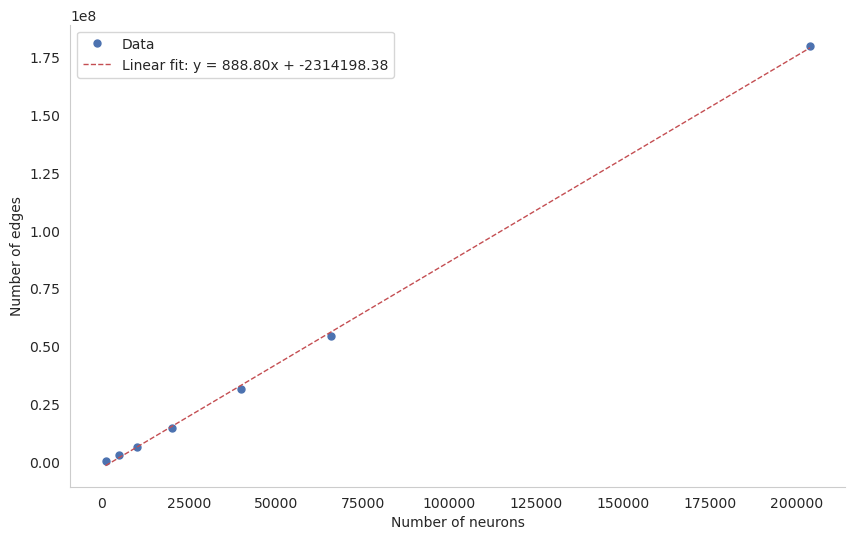

In [23]:
edges = df['n_edges']#.unique()
neurons = df['n_neurons']#.unique()
mem = df['mean_gpu_memory']
time = df['mean_step_time']

plt.figure(figsize=(10, 6))
plt.plot(neurons, edges, 'o', markersize=5)

# include a linear fit
# fit a line to the data
z = np.polyfit(neurons, edges, 1)
p = np.poly1d(z)
plt.plot(neurons, p(neurons), 'r--', linewidth=1)
# include a legend with the fit parameters
plt.legend(['Data', 'Linear fit: y = {:.2f}x + {:.2f}'.format(z[0], z[1])], loc='upper left')

plt.xlabel('Number of neurons')
# plt.ylabel('Number of neurons')
plt.ylabel('Number of edges')
# plt.title('Number of edges vs number of neurons')
plt.grid()
plt.show()

In [24]:
0.000149*475000+2.33

73.10499999999999

Number of neurons for 48GB of memory: 283838.32335329347
Number of neurons for 80GB of memory: 475455.08982035925
Number of neurons for 188GB of memory: 840724.5508982037
Memory for 203816 neurons: 34.636272 GB


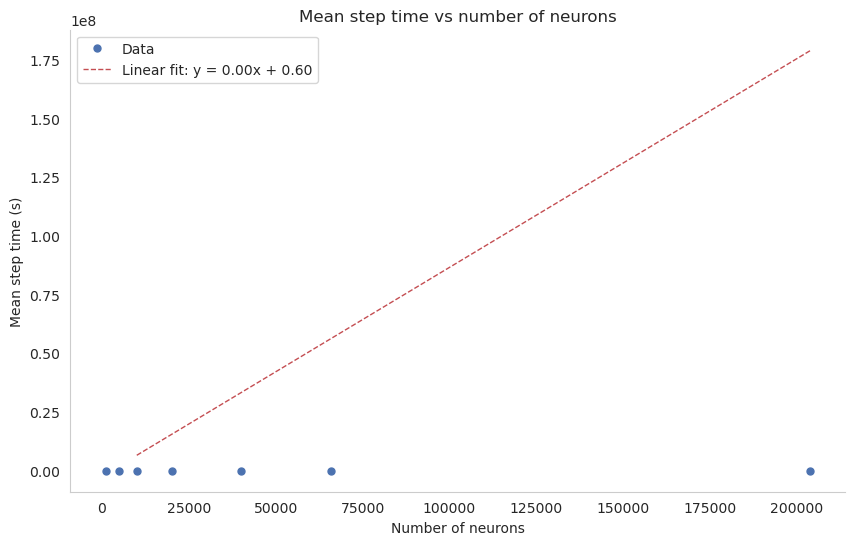

In [25]:
plt.figure(figsize=(10, 6))

# include a linear fit
# fit a line to the data
x = neurons
y = time
plt.plot(x, y, 'o', markersize=5)

# z = np.polyfit(x[2:], y[2:], 1)
z = [0.000167, 0.599]
# p = np.poly1d(z)
plt.plot(x[2:], p(x[2:]), 'r--', linewidth=1)
# include a legend with the fit parameters
plt.legend(['Data', 'Linear fit: y = {:.2f}x + {:.2f}'.format(z[0], z[1])], loc='upper left')

# using this fit, calculate the number of neurons for 48GB, 80GB, 188GB of memory
neurons_for_48GB = (48 - z[1]) / z[0]
print(f'Number of neurons for 48GB of memory: {neurons_for_48GB}')

neurons_for_80GB = (80 - z[1]) / z[0]
print(f'Number of neurons for 80GB of memory: {neurons_for_80GB}')

neurons_for_188GB = (141 - z[1]) / z[0]
print(f'Number of neurons for 188GB of memory: {neurons_for_188GB}')

# calculate the memory for 203816 neurons
sample_neurons = 203816
sample_mem = z[0] * sample_neurons + z[1]
print(f'Memory for {sample_neurons} neurons: {sample_mem} GB')

# convert x axis to logscale
# plt.xscale('log')
plt.xlabel('Number of neurons')
# plt.ylabel('Number of neurons')
plt.ylabel('Mean step time (s)')
plt.title('Mean step time vs number of neurons')
plt.grid()
plt.show()

In [26]:
df

,n_neurons,n_edges,batch_size,seq_len,mean_rate,sem_rate,mean_step_time,sem_step_time,mean_gpu_memory,sem_gpu_memory
0,1000,544263,1.0,1000.0,0.0036,0.0,3.60200,0.01365,2.00505,0.00815
1,5000,3074601,1.0,1000.0,0.0036,0.0,3.82650,0.00505,1.53895,0.00125
2,10000,6645432,1.0,1000.0,0.0035,0.0,3.95835,0.00525,1.90885,0.00080
3,20000,14807994,1.0,1000.0,0.0036,0.0,4.75040,0.00630,3.48880,0.00105
4,40000,31863080,1.0,1000.0,0.0035,0.0,7.05280,0.00785,6.81810,0.00155
5,65871,54378241,1.0,1000.0,0.0036,0.0,11.45240,0.00845,11.29420,0.00260
6,203816,179735332,1.0,1000.0,0.0037,0.0,33.20000,0.01940,34.90000,0.03140
